<a href="https://colab.research.google.com/github/jacobhill2002/BME450-applehealthdetection/blob/main/appleClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
%matplotlib inline

Mounted at /content/drive


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir_1, data_dir_2):
        self.data_dir_1 = data_dir_1
        self.data_dir_2 = data_dir_2
        self.image_filenames = []
        self.labels = []
        for image_filename in os.listdir(data_dir_1):
            self.image_filenames.append(os.path.join(data_dir_1, image_filename))
            self.labels.append(0)
        for image_filename in os.listdir(data_dir_2):
            self.image_filenames.append(os.path.join(data_dir_2, image_filename))
            self.labels.append(1)
        self.transforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.classes = ['fresh', 'rotten']

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image_filename = self.image_filenames[index]
        label = self.labels[index]
        image = Image.open(image_filename)
        image = self.transforms(image)
        image = (image - image.min()) / (image.max() - image.min())  # normalize to 0-1 range
        image = image.squeeze(0)
        return image, label

In [ ]:
data_dir_1 = "/content/drive/MyDrive/BME-450/original_data_set/freshapplesRGB"
data_dir_2 = "/content/drive/MyDrive/BME-450/original_data_set/rottenapplesRGB"
dataset = CustomDataset(data_dir_1, data_dir_2)

test_dir_1 = "/content/drive/MyDrive/BME-450/original_data_set/testfresh1"
test_dir_2 = "/content/drive/MyDrive/BME-450/original_data_set/testrotten1"
test_dataset = CustomDataset(test_dir_1, test_dir_2)

In [ ]:
import matplotlib.pyplot as plt
dataset_size = len(dataset)
test_dataset_size = len(test_dataset)
classes = dataset.classes
img, label = dataset[0]
num_classes = len(dataset.classes)
img, label = dataset[0]

In [ ]:
x = []
for i in range(dataset_size):
    x.append(dataset[i][1])
uimg = torch.tensor(x).unique(sorted=True)
uimg_count = torch.stack([(torch.tensor(x)==i).sum() for i in uimg])
for i in range(len(uimg)):
    print(f'{classes[i]}: {uimg_count[i].item()} count')

fresh: 222 count
rotten: 302 count


In [ ]:
torch.manual_seed(43)
val_size = 80
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(444, 80)

In [ ]:
batch_size=4

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)


In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x



Using cuda device.
Epoch 1/35 | Train Loss: 0.67920 | Train Acc: 61.04% | Val Loss: 0.68982 | Val Acc: 48.75% | Test Loss: 0.69012 | Test Acc: 50.00%
Epoch 2/35 | Train Loss: 0.66648 | Train Acc: 63.74% | Val Loss: 0.66286 | Val Acc: 61.25% | Test Loss: 0.67074 | Test Acc: 60.00%
Epoch 3/35 | Train Loss: 0.62507 | Train Acc: 71.17% | Val Loss: 0.61214 | Val Acc: 73.75% | Test Loss: 0.64004 | Test Acc: 65.00%
Epoch 4/35 | Train Loss: 0.54924 | Train Acc: 81.98% | Val Loss: 0.49022 | Val Acc: 83.75% | Test Loss: 0.53017 | Test Acc: 80.00%
Epoch 5/35 | Train Loss: 0.41835 | Train Acc: 92.12% | Val Loss: 0.44266 | Val Acc: 80.00% | Test Loss: 0.44194 | Test Acc: 77.50%
Epoch 6/35 | Train Loss: 0.34357 | Train Acc: 94.14% | Val Loss: 0.26318 | Val Acc: 91.25% | Test Loss: 0.29333 | Test Acc: 90.00%
Epoch 7/35 | Train Loss: 0.28467 | Train Acc: 95.95% | Val Loss: 0.28463 | Val Acc: 91.25% | Test Loss: 0.24436 | Test Acc: 92.50%
Epoch 8/35 | Train Loss: 0.26428 | Train Acc: 96.85% | Val Loss:

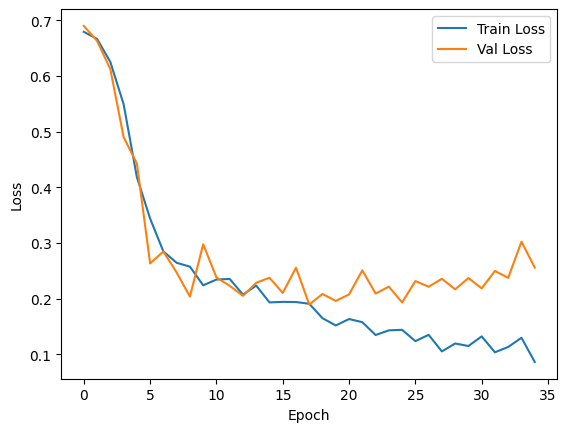

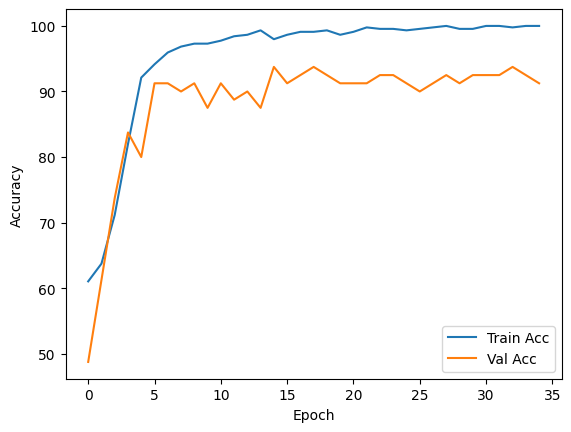

In [ ]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=0.01)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device.')

model = model.to(device)

n_epochs = 20
train_losses, train_accs, val_losses, val_accs, test_losses, test_accs = [], [], [], [], [], []

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += criterion(outputs, labels).item()
    accuracy = 100 * correct / total
    loss /= len(loader)
    return accuracy, loss

for epoch in range(n_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    test_loss = 0.0
    test_acc = 0.0

    # train
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        acc, _ = evaluate(model, [(images, labels)])
        train_acc += acc

    # evaluate on validation set
    model.eval()
    val_acc, val_loss = evaluate(model, val_loader)

    # Evaluate on test set
    if test_loader is not None:
        test_acc, test_loss = evaluate(model, test_loader)

    # store results for plotting
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_acc / len(train_loader))
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if test_loader is not None:
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # print progress
    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {train_loss/len(train_loader):.5f} | "
          f"Train Acc: {train_acc/len(train_loader):.2f}% | "
          f"Val Loss: {val_loss:.5f} | "
          f"Val Acc: {val_acc:.2f}%", end='')
    if test_loader is not None:
        print(f" | Test Loss: {test_loss:.5f} | "
              f"Test Acc: {test_acc:.2f}%")
    else:
        print()

# plot results
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


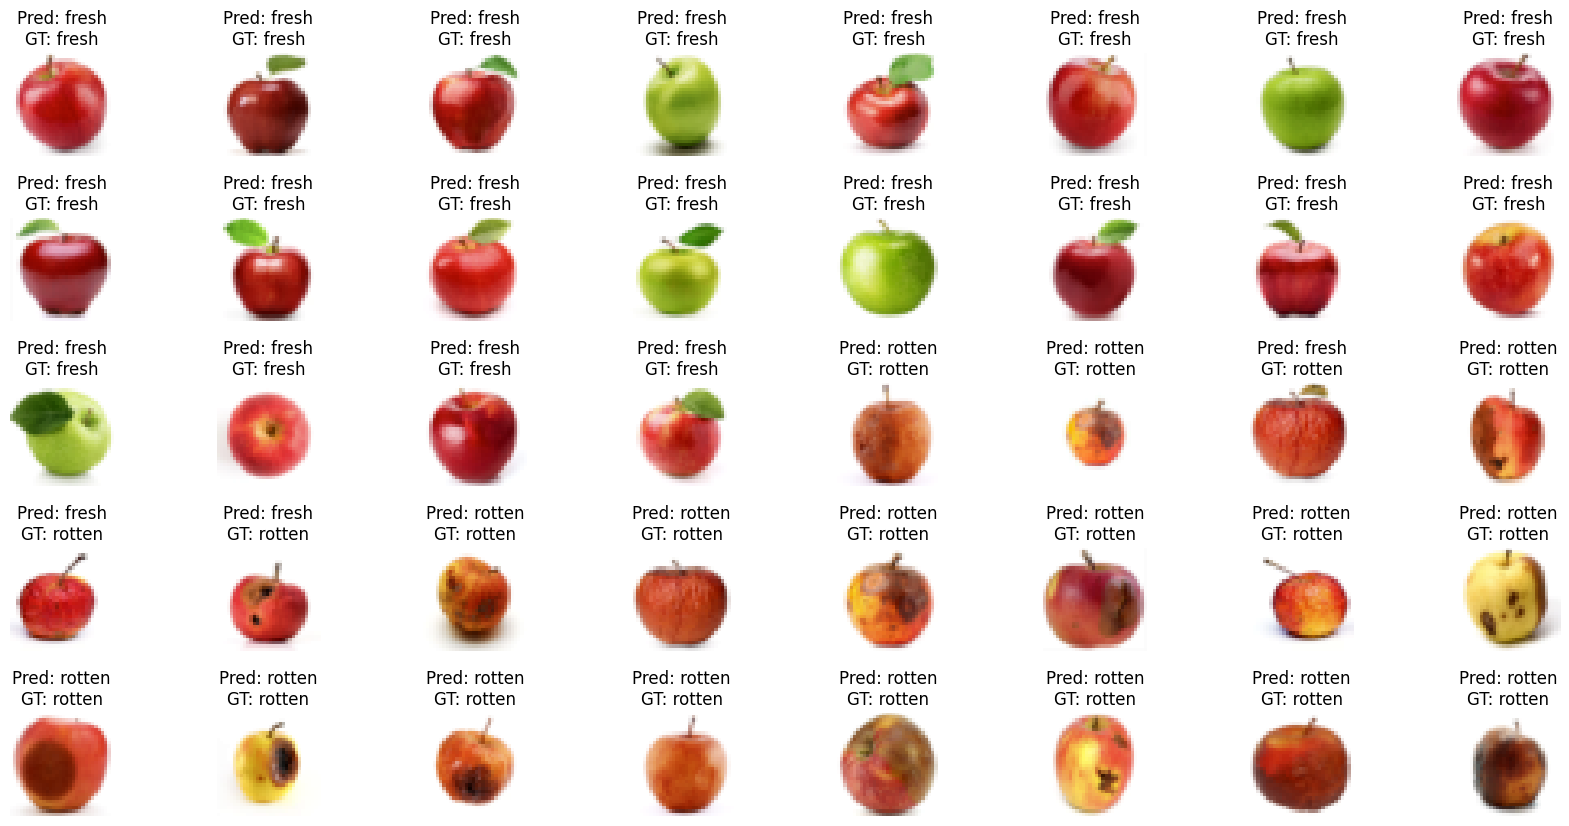

In [ ]:
class_labels = ["fresh", "rotten"]

def plot_images(images, pred_labels, true_labels, num_images=40):
    fig, axes = plt.subplots(5, 8, figsize=(20, 10))
    axes = axes.ravel()

    for i in np.arange(0, num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        axes[i].set_title(f"Pred: {class_labels[pred_labels[i]]}\nGT: {class_labels[true_labels[i]]}")

    plt.subplots_adjust(wspace=1, hspace=0.5)

pred_labels = []
true_labels = []
images = np.empty((0,32,32,3), dtype=np.float32)

for x_test, y_test in test_loader:
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_pred = model(x_test)
    
    # convert the tensor to a numpy array and transpose the dimensions
    x_test = x_test.cpu().numpy().transpose((0, 2, 3, 1)).astype(np.float32)

    # append the predicted and true labels and image arrays to the lists
    pred_labels += y_pred.argmax(dim=1).tolist()
    true_labels += y_test.tolist()
    images = np.concatenate((images, x_test), axis=0)

plot_images(images, pred_labels, true_labels)


In [ ]:
def test(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    tp_fresh = 0
    tp_rotten = 0
    fn_fresh = 0
    fn_rotten = 0
    fp_fresh = 0
    fp_rotten = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # compute true positive rate, false positives, and false negatives for each class
            tp_fresh += ((predicted == 0) & (labels == 0)).sum().item()
            tp_rotten += ((predicted == 1) & (labels == 1)).sum().item()
            fn_fresh += ((predicted != labels) & (labels == 0)).sum().item()
            fn_rotten += ((predicted != labels) & (labels == 1)).sum().item()
            fp_fresh += ((predicted == 1) & (labels == 0)).sum().item()
            fp_rotten += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = 100 * correct / total
    tpr_fresh = 100 * tp_fresh / (tp_fresh + fn_fresh)
    tpr_rotten = 100 * tp_rotten / (tp_rotten + fn_rotten)
    fn_fresh = 100 * fn_fresh / total
    fn_rotten = 100 * fn_rotten / total
    fp_fresh = 100 * fp_fresh / total
    fp_rotten = 100 * fp_rotten / total

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'TP Fresh: {tpr_fresh:.2f}%, FP Fresh: {fp_fresh:.2f}%, FN Fresh: {fn_fresh:.2f}%')
    print(f'TP Rotten: {tpr_rotten:.2f}%, FP Rotten: {fp_rotten:.2f}%, FN Rotten: {fn_rotten:.2f}%')

    return accuracy, tpr_fresh, tpr_rotten, fn_fresh, fn_rotten, fp_fresh, fp_rotten



In [ ]:
test(model,val_loader,device)

Accuracy: 91.25%
TP Fresh: 95.12%, FP Fresh: 2.50%, FN Fresh: 2.50%
TP Rotten: 87.18%, FP Rotten: 6.25%, FN Rotten: 6.25%


(91.25, 95.1219512195122, 87.17948717948718, 2.5, 6.25, 2.5, 6.25)

In [ ]:
# RGBA TO RGB CODE

# from PIL import Image
# import os

# # Specify the paths to the input and output folders
# input_folder = '/content/drive/MyDrive/BME-450/original_data_set/rottenapples'
# output_folder = '/content/drive/MyDrive/BME-450/original_data_set/rottenapplesRGB'

# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# for filename in os.listdir(input_folder):
#     # Check if the file is a PNG or JPG image
#     if filename.endswith('.png') or filename.endswith('.jpg'):
#         # Open the image
#         image = Image.open(os.path.join(input_folder, filename))
        
#         if image.mode == 'RGBA':
#             image = image.convert('RGB')
        
#         output_path = os.path.join(output_folder, filename)
#         image.save(output_path)

